# Compute embeddings of nucleotides

In [1]:
from embedding import seq2embedding
import os
import random
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import tqdm

/opt/anaconda3/envs/torch201/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.chdir('/picb/rnasys2/zhouhanwen/nucTran/github/')

## Process data

In [3]:
rna_df = pd.read_csv('embedding/data/Rna/rna_gencode.tsv', sep='\t')
# Sample one transcript from each gene in order to avoid similar sequences
np.random.seed(2024)
rna_df = rna_df.groupby('gene_id').sample(1)
# Select curated mRNAs and lncRNAs with length <= 4096
rna_df['seq_len'] = rna_df['seq'].apply(lambda x: len(x))
rna_df = rna_df[rna_df['seq_len'] <= 4096]
len(rna_df)

42742

## Compute embeddings

In [4]:
mrna_df = rna_df[rna_df['label'] == 'protein_coding']
lncrna_df = rna_df[rna_df['label'] == 'lncRNA']

In [5]:
def compute_nucleotide_embedding_mean(model_state_path=None, model_max_length=15000, seed=None, gpu_i=0):
    """
    Compute the means of embeddings of nucleotides of mRNAs and lncRNAs
    Params:
        model_state_path: Path of pretrained weight; = None if training or inference from scratch
        model_max_length: Max length of tokenizer
        seed: Random seed
        gpu_i: Index of GPU
        
    Return:
        embedding_means: Means of embeddings, 2-dimension list
        distances: Distances, 3-dimension list
    """
    np.random.seed(seed)
    mrna_seqs = mrna_df['seq'].sample(500).values.tolist()
    lncrna_seqs = lncrna_df['seq'].sample(500).values.tolist()
    seqs = mrna_seqs + lncrna_seqs
    print(len(seqs))
    labels = []
    for ele in seqs:
        labels.extend(list(ele))
    
    embeddings, _ = seq2embedding(seqs, 'nucleotide', model_state_path, model_max_length, return_embedding=False, gpu_i=gpu_i)
    n_embeddings = []
    for embedding in embeddings:
        n_embeddings.extend(embedding)
    n_embeddings = np.array(n_embeddings)
    print(n_embeddings.shape)
    a_indices = [i for i, nucleotide in enumerate(labels) if nucleotide == 'A']
    t_indices = [i for i, nucleotide in enumerate(labels) if nucleotide == 'T']
    c_indices = [i for i, nucleotide in enumerate(labels) if nucleotide == 'C']
    g_indices = [i for i, nucleotide in enumerate(labels) if nucleotide == 'G']
    a_embeddings = n_embeddings[a_indices]
    t_embeddings = n_embeddings[t_indices]
    c_embeddings = n_embeddings[c_indices]
    g_embeddings = n_embeddings[g_indices]
    a_embedding_mean = np.mean(a_embeddings, axis=0)
    t_embedding_mean = np.mean(t_embeddings, axis=0)
    c_embedding_mean = np.mean(c_embeddings, axis=0)
    g_embedding_mean = np.mean(g_embeddings, axis=0)
    embedding_means = np.array([a_embedding_mean, t_embedding_mean, c_embedding_mean, g_embedding_mean])
    distances = cosine_distances(embedding_means)
            
    return embedding_means, distances

In [6]:
embedding_means_multiple, distances_multiple = [], []
for i in range(10):
    print(i)
    embedding_means, distances = compute_nucleotide_embedding_mean(model_state_path='pretrain/saving_model/mammalian80D_4096len1mer1sw_80M/checkpoint-250000/model.safetensors', model_max_length=15000, seed=2024+i, gpu_i=1)
    embedding_means_multiple.append(embedding_means)
    distances_multiple.append(distances)

0
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:56<00:00,  8.59it/s]


(1357656, 768)
1
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.15it/s]


(1354868, 768)
2
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:03<00:00,  8.09it/s]


(1368747, 768)
3
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


(1383492, 768)
4
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:54<00:00,  8.73it/s]


(1351884, 768)
5
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:56<00:00,  8.59it/s]


(1318488, 768)
6
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:54<00:00,  8.73it/s]


(1323583, 768)
7
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.91it/s]


(1337804, 768)
8
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.54it/s]


(1345705, 768)
9
1000


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.37it/s]


(1326802, 768)


In [7]:
embedding_means_multiple = np.array(embedding_means_multiple)
embedding_means_multiple = embedding_means_multiple.reshape(-1, 768)
embedding_means_multiple.shape

(40, 768)

In [8]:
np.save('embedding/data/Nucleotide/nucleotide_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_500mRNA_500lncRNA_seqlenlt4096_10times.npy', embedding_means_multiple)

## PCA

In [9]:
pca = PCA(n_components=2)

In [10]:
pca.fit(embedding_means_multiple)

PCA(n_components=2)

In [11]:
print(pca.explained_variance_ratio_)

[0.37999625 0.32595393]


In [12]:
embedding_means_pca = pca.fit_transform(embedding_means_multiple)
embedding_means_pca

array([[ 2.8298349 , -2.80819625],
       [-3.78220226, -4.95890964],
       [-4.75770562,  5.25349763],
       [ 5.70908538,  2.48488519],
       [ 2.837953  , -2.82905275],
       [-3.79285306, -4.99668309],
       [-4.77509708,  5.2887036 ],
       [ 5.72310375,  2.4927854 ],
       [ 2.8199295 , -2.78548372],
       [-3.76329108, -4.9360598 ],
       [-4.7177122 ,  5.2773074 ],
       [ 5.67869754,  2.50093438],
       [ 2.83209386, -2.83823747],
       [-3.78697647, -4.99097838],
       [-4.75537281,  5.20748895],
       [ 5.70097485,  2.4375506 ],
       [ 2.82170394, -2.84410693],
       [-3.80040625, -5.01222962],
       [-4.76802932,  5.2087608 ],
       [ 5.69478731,  2.43064218],
       [ 2.81369999, -2.79824936],
       [-3.7642441 , -4.93319331],
       [-4.72173267,  5.25612384],
       [ 5.68372504,  2.49476091],
       [ 2.80955162, -2.77751142],
       [-3.75222535, -4.92317711],
       [-4.72154976,  5.27968718],
       [ 5.6614945 ,  2.50446002],
       [ 2.83149317,

In [13]:
labels = ['blue', 'green', 'red', 'purple'] * 10

ATCG

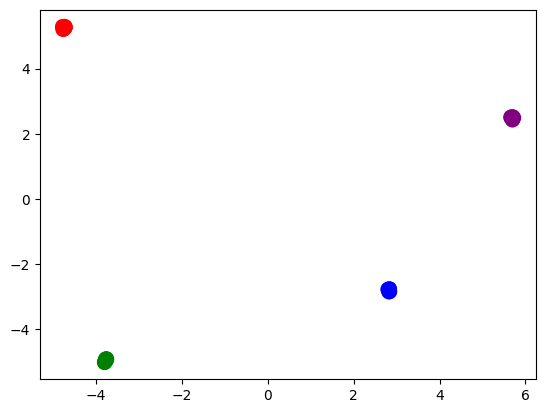

In [14]:
plt.scatter(embedding_means_pca[:, 0], embedding_means_pca[:, 1], c=labels, s=100)

In [15]:
pca_df = pd.DataFrame(embedding_means_pca)
pca_df.columns = ['pca1', 'pca2']
pca_df['label'] = labels
pca_df

,pca1,pca2,label
0,2.829835,-2.808196,blue
1,-3.782202,-4.958910,green
2,-4.757706,5.253498,red
3,5.709085,2.484885,purple
4,2.837953,-2.829053,blue
5,-3.792853,-4.996683,green
6,-4.775097,5.288704,red
7,5.723104,2.492785,purple
8,2.819929,-2.785484,blue
9,-3.763291,-4.936060,green


In [16]:
pca_df.to_csv('embedding/data/Nucleotide/nucleotide_embedding_mean_pca_mammalian80D_4096len1mer1sw_80M_250k_500mRNA_500lncRNA_seqlenlt4096_10times.csv', index=False)

## distances

In [17]:
distances_multiple = np.array(distances_multiple)
distances_multiple = distances_multiple.reshape(-1, 4)
distances_multiple.shape

(40, 4)

In [18]:
dist_df = pd.DataFrame(distances_multiple)
dist_df.columns = ['A', 'T', 'C', 'G']

In [19]:
dist_df.to_csv('embedding/data/Nucleotide/nucleotide_embedding_mean_distance_mammalian80D_4096len1mer1sw_80M_250k_500mRNA_500lncRNA_seqlenlt4096_10times.csv', index=False)

In [20]:
dist_df

,A,T,C,G
0,0.000000,0.163469,0.173984,0.155754
1,0.163469,0.000000,0.164357,0.185308
2,0.173984,0.164357,0.000000,0.183509
3,0.155754,0.185308,0.183509,0.000000
4,0.000000,0.163298,0.174419,0.156233
5,0.163298,0.000000,0.164564,0.184804
6,0.174419,0.164564,0.000000,0.183080
7,0.156233,0.184804,0.183080,0.000000
8,0.000000,0.162038,0.172625,0.154731
9,0.162038,0.000000,0.163852,0.183780
